# Deployment Risk Prediction PoC

This notebook generates synthetic operational data and forecasts deployment risk windows with Google's TimesFM.

## 1) Setup


In [1]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
np.random.seed(42)

DATA_DIR = Path("data")
OUT_DIR = Path("output")
DATA_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

START_DATE = "2024-01-01"
END_DATE = "2024-12-31 23:00:00"


## 2) Generate synthetic data

Data generation lives in `synthetic_data.py`. Replace it with your own loader if you have real operational data — just match the expected DataFrame schemas:

- `match_events` -> `timestamp`, `tournament`, `traffic_multiplier`
- `deploy_events` -> `timestamp`, `is_critical_fix`, `deploy_size`
- `incidents` -> `timestamp`, `incident_type`, `severity`

In [2]:
from synthetic_data import generate_match_events, generate_deploy_events, generate_incidents

In [3]:
matches_df = generate_match_events(START_DATE, END_DATE)
deploys_df = generate_deploy_events(START_DATE, END_DATE)
incidents_df = generate_incidents(deploys_df, matches_df)

matches_df.to_csv(DATA_DIR / "match_events.csv", index=False)
deploys_df.to_csv(DATA_DIR / "deploy_events.csv", index=False)
incidents_df.to_csv(DATA_DIR / "incidents.csv", index=False)

print("match events:", len(matches_df))
print("deploy events:", len(deploys_df))
print("incidents:", len(incidents_df))
incidents_df.head()


match events: 1363
deploy events: 3447
incidents: 246


,timestamp,incident_type,severity
0,2024-01-03 20:26:00,load_incident,high
1,2024-01-04 15:07:00,deploy_incident,medium
2,2024-01-04 16:31:00,load_incident,low
3,2024-01-04 19:40:00,load_incident,medium
4,2024-01-11 17:42:00,deploy_incident,medium


### Pattern checks (sanity validation)


In [4]:
# Deploy volume pattern checks
by_dow = deploys_df.assign(day=deploys_df["timestamp"].dt.day_name()).groupby("day").size()
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
by_dow = by_dow.reindex(day_order).fillna(0)
print("Deploys by day:")
print(by_dow)

hourly_deploy = deploys_df.assign(hour=deploys_df["timestamp"].dt.hour).groupby("hour").size()
print("\nTop deploy hours:")
print(hourly_deploy.sort_values(ascending=False).head(8))

# Match event concentration checks
match_dow = matches_df.assign(day=matches_df["timestamp"].dt.day_name()).groupby("day").size().reindex(day_order).fillna(0)
print("\nMatch events by day:")
print(match_dow)


Deploys by day:
day
Monday       810
Tuesday      778
Wednesday    700
Thursday     713
Friday       375
Saturday      42
Sunday        29
dtype: int64

Top deploy hours:
hour
16    412
17    408
13    281
14    269
15    265
11    240
12    234
10    218
dtype: int64

Match events by day:
day
Monday         0.0
Tuesday        0.0
Wednesday    474.0
Thursday     451.0
Friday         0.0
Saturday     219.0
Sunday       219.0
dtype: float64


## 3) Prepare time series for TimesFM


In [5]:
def create_hourly_risk_series(incidents_df):
    """
    Aggregate incidents into hourly counts.
    Returns pandas Series with DatetimeIndex and hourly frequency.
    """
    if incidents_df.empty:
        idx = pd.date_range(start=START_DATE, end=END_DATE, freq="h")
        return pd.Series(0.0, index=idx, name="risk_incidents")

    s = (
        incidents_df.assign(hour=incidents_df["timestamp"].dt.floor("h"))
        .groupby("hour")
        .size()
        .astype(float)
        .sort_index()
    )

    full_idx = pd.date_range(start=START_DATE, end=END_DATE, freq="h")
    s = s.reindex(full_idx, fill_value=0.0)
    s = s.asfreq("h", fill_value=0.0)
    s.name = "risk_incidents"
    return s


risk_series = create_hourly_risk_series(incidents_df)
risk_series.to_frame().to_csv(DATA_DIR / "hourly_risk_series.csv", index_label="timestamp")
print(risk_series.head())
print("rows:", len(risk_series))


2024-01-01 00:00:00    0.0
2024-01-01 01:00:00    0.0
2024-01-01 02:00:00    0.0
2024-01-01 03:00:00    0.0
2024-01-01 04:00:00    0.0
Freq: h, Name: risk_incidents, dtype: float64
rows: 8784


## 4) Run TimesFM forecast


In [6]:
import timesfm

HORIZON_LEN = 168  # 7 days ahead
CONTEXT_LEN = 512

tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        context_len=CONTEXT_LEN,
        horizon_len=HORIZON_LEN,
        per_core_batch_size=32,
        backend="cpu",
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        version="torch",
        huggingface_repo_id="google/timesfm-1.0-200m-pytorch",
    ),
)

historical = risk_series.values[-CONTEXT_LEN:].astype(np.float32)
mean_forecast, full_forecast = tfm.forecast([historical], freq=[0])

forecast_values = mean_forecast[0][:HORIZON_LEN].astype(float)
forecast_index = pd.date_range(start=risk_series.index[-1] + pd.Timedelta(hours=1), periods=HORIZON_LEN, freq="h")
forecast_series = pd.Series(forecast_values, index=forecast_index, name="forecast_risk")

print("forecast shape:", forecast_series.shape)
forecast_series.head()

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.


Loaded PyTorch TimesFM, likely because python version is 3.11.14 (main, Oct  9 2025, 16:16:55) [Clang 17.0.0 (clang-1700.6.3.2)].


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

forecast shape: (168,)


2025-01-01 00:00:00   -0.003524
2025-01-01 01:00:00   -0.005054
2025-01-01 02:00:00   -0.001450
2025-01-01 03:00:00   -0.003242
2025-01-01 04:00:00   -0.001372
Freq: h, Name: forecast_risk, dtype: float64

## 5) Visualize


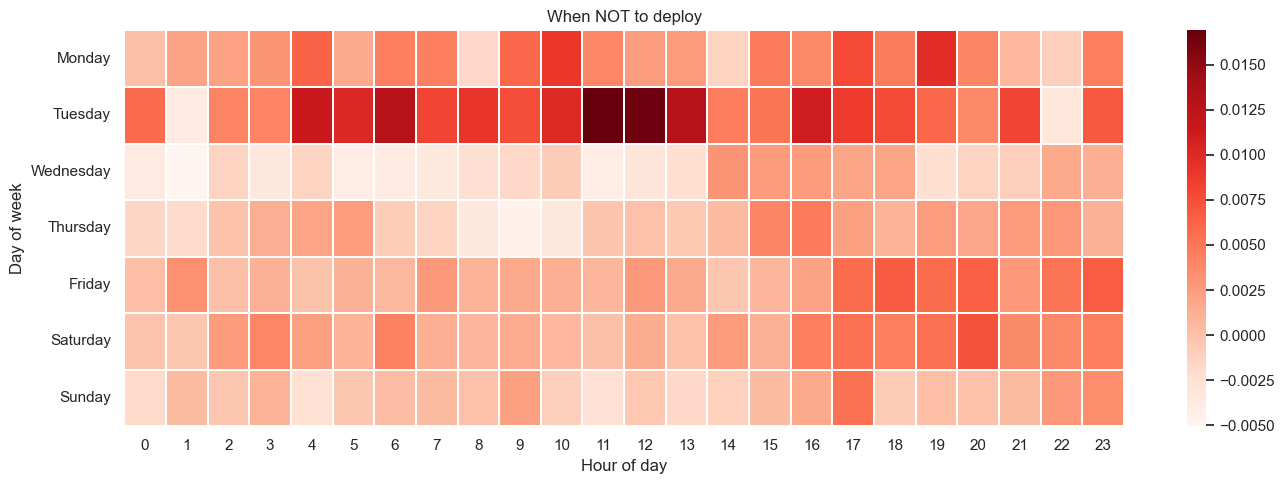

In [7]:
# Output 1: Risk heatmap (When NOT to deploy)
plot_df = forecast_series.to_frame().reset_index().rename(columns={"index": "timestamp"})
plot_df["dow"] = plot_df["timestamp"].dt.day_name()
plot_df["hour"] = plot_df["timestamp"].dt.hour

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap = (
    plot_df.pivot_table(index="dow", columns="hour", values="forecast_risk", aggfunc="mean")
    .reindex(day_order)
    .fillna(0.0)
)

plt.figure(figsize=(14, 5))
ax = sns.heatmap(heatmap, cmap="Reds", linewidths=0.2)
ax.set_title("When NOT to deploy")
ax.set_xlabel("Hour of day")
ax.set_ylabel("Day of week")
plt.tight_layout()
plt.savefig(OUT_DIR / "risk_heatmap.png", dpi=150)
plt.show()


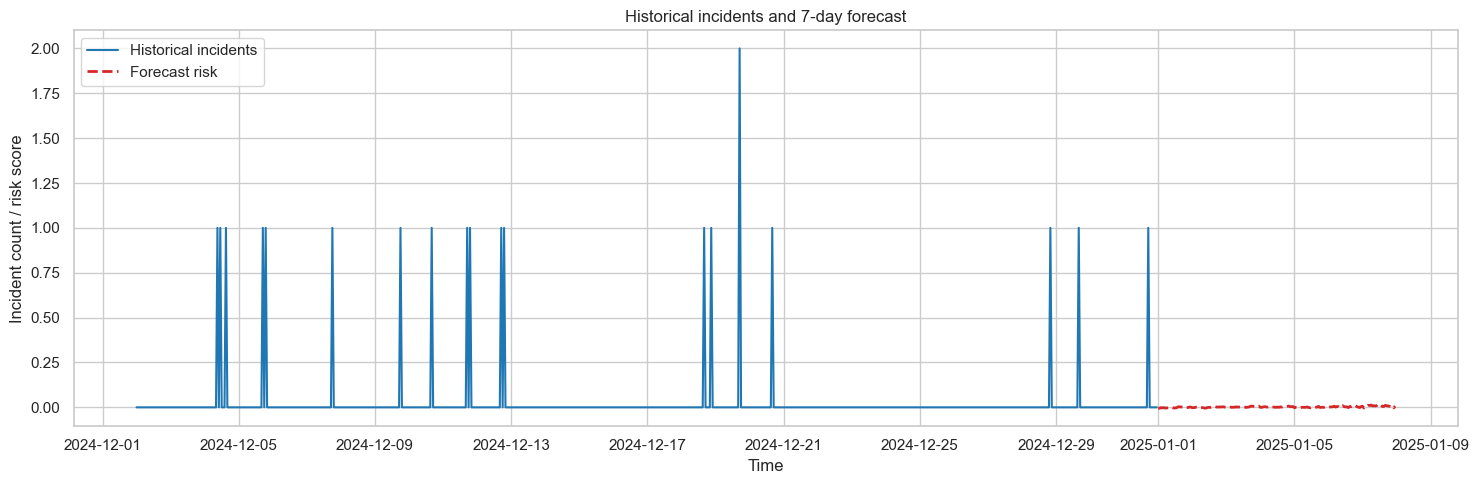

In [8]:
# Output 2: Historical series + forecast + match overlay
hist_window = 24 * 30
hist = risk_series.iloc[-hist_window:]

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(hist.index, hist.values, label="Historical incidents", color="#1f77b4", linewidth=1.5)
ax.plot(forecast_series.index, forecast_series.values, label="Forecast risk", linestyle="--", color="#d62728", linewidth=2)

future_matches = matches_df[(matches_df["timestamp"] >= forecast_series.index.min()) & (matches_df["timestamp"] <= forecast_series.index.max())]
for ts in future_matches["timestamp"].dt.floor("h").drop_duplicates():
    ax.axvline(ts, color="#ff7f0e", alpha=0.08)

ax.set_title("Historical incidents and 7-day forecast")
ax.set_xlabel("Time")
ax.set_ylabel("Incident count / risk score")
ax.legend(loc="upper left")
plt.tight_layout()
plt.savefig(OUT_DIR / "forecast_timeseries.png", dpi=150)
plt.show()


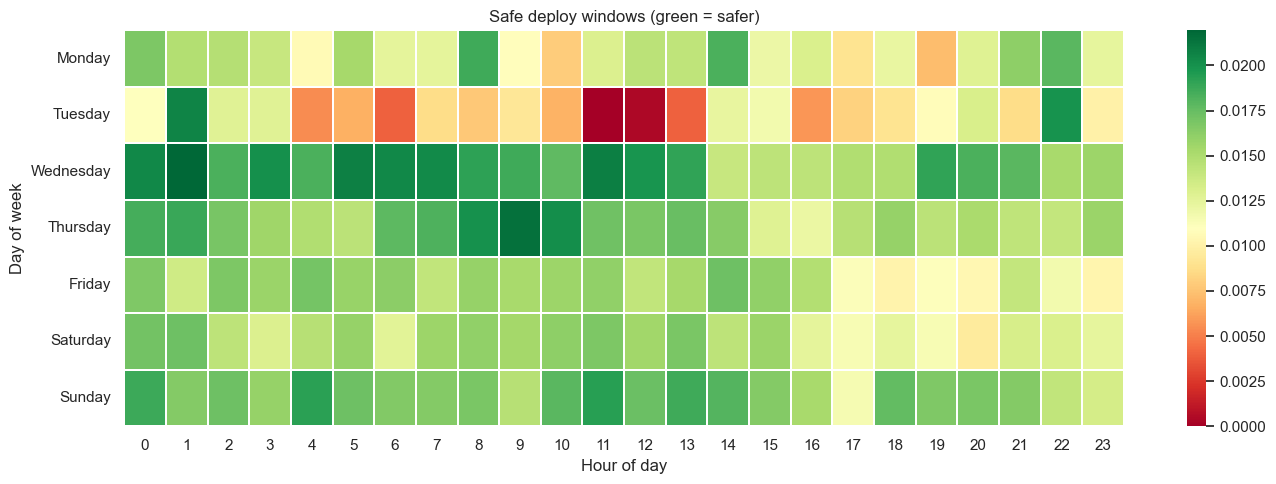

In [9]:
# Output 3: Safe deploy windows (inverted scale)
safe = heatmap.max().max() - heatmap

plt.figure(figsize=(14, 5))
ax = sns.heatmap(safe, cmap="RdYlGn", linewidths=0.2)
ax.set_title("Safe deploy windows (green = safer)")
ax.set_xlabel("Hour of day")
ax.set_ylabel("Day of week")
plt.tight_layout()
plt.savefig(OUT_DIR / "safe_windows_heatmap.png", dpi=150)
plt.show()


## 6) Insights

- The synthetic generator creates expected pressure zones: midweek evening traffic and late-afternoon deploy intensity.
- The risk signal generally highlights Wed/Thu overlap windows and Friday late-afternoon rush.
- This remains a PoC: synthetic assumptions, simple probability model, and no production feedback loop.
